In [1]:
# ===== DOCUMENTAÇÃO: PROTOCOLO DE MANCHESTER PARA QUEDAS =====
# Este bloco fornece a descrição completa do protocolo de Manchester (queda)
# e apresenta a interface inicial do sistema ao usuário.

"""
# PROTOCOLO DE MANCHESTER - FLUXOGRAMA DE QUEDAS

O Sistema de Triagem de Manchester é um método de classificação de urgência amplamente utilizado
em serviços de emergência hospitalares. No caso específico de quedas, o protocolo avalia fatores
como mecanismo do trauma, sintomas apresentados, e riscos associados para atribuir uma prioridade
de atendimento ao paciente.

## NÍVEIS DE TRIAGEM

1. VERMELHO (Emergência) - Atendimento Imediato
   - Critérios para quedas:
     * Obstrução de vias aéreas
     * Respiração inadequada
     * Choque (hipotensão, taquicardia, alteração da consciência)
     * Convulsões ativas
     * Hipoglicemia severa (<55mg/dL)
     * Hemorragia exsanguinante

2. LARANJA (Muito Urgente) - Atendimento em até 10 minutos
   - Critérios para quedas:
     * Mecanismo de trauma significativo (queda >1m altura)
     * Dor intensa (8-10/10)
     * Déficit neurológico agudo
     * Alteração súbita da consciência
     * Hipotermia (<35°C)

3. AMARELO (Urgente) - Atendimento em até 60 minutos
   - Critérios para quedas:
     * História de inconsciência após a queda
     * Distúrbio de coagulação (uso de anticoagulantes)
     * Fratura exposta ou deformidade importante
     * Dor moderada (4-7/10)
     * Déficit neurológico novo (não agudo)

4. VERDE (Pouco Urgente) - Atendimento em até 120 minutos
   - Critérios para quedas:
     * Dor leve (1-3/10)
     * Edema ou hematoma localizado
     * Evento recente sem sinais de alarme

5. AZUL (Não Urgente) - Atendimento em até 240 minutos
   - Casos sem critérios para classificações anteriores
   - Sem sinais de risco

## REGRAS ESPECÍFICAS PARA QUEDAS

### Avaliação de Risco Crítico (Vermelho)
- Verificar sinais de choque: FC>100, PA<90/60, sudorese, palidez
- Avaliar padrão respiratório e saturação de O2
- Verificar nível de consciência (Escala de Glasgow)
- Avaliar glicemia capilar se houver alteração da consciência

### Mecanismo de Trauma (Laranja)
- Quedas de altura superior a 1 metro
- Quedas em escadas com mais de 5 degraus
- Trauma penetrante ou com transferência de energia (colisões)

### Fatores de Alto Risco (Amarelo)
- Uso de anticoagulantes (varfarina, DOAC)
- Idade >65 anos com comorbidades
- História de perda de consciência após a queda
- Histórico discordante (suspeita de abuso em populações vulneráveis)

### Características Específicas do Fluxograma
- Considerar sempre o pior cenário ao atribuir a prioridade
- Reavaliar o paciente se houver deterioração clínica
- Para cada discriminador, seguir a árvore de decisão do fluxograma
- Documentar claramente a justificativa da classificação

Este protocolo específico para quedas é fundamental para identificar rapidamente pacientes
com risco potencial de lesões graves, como traumatismo cranioencefálico, fraturas, hemorragias
internas ou comprometimento neurológico.
"""

# Imprimir um resumo para o usuário ao executar o notebook
print("=" * 80)
print("SISTEMA DE SUPORTE À DECISÃO - TRIAGEM DE MANCHESTER PARA QUEDAS")
print("=" * 80)
print("Este notebook implementa um modelo de linguagem (LLM) fine-tuned")
print("para auxiliar na classificação de pacientes segundo o Protocolo de Manchester,")
print("especificamente para o fluxograma de QUEDAS.")
print("\nO sistema atribui uma das cinco cores de prioridade:")
print("  - VERMELHO: Emergência (atendimento imediato)")
print("  - LARANJA: Muito Urgente (até 10 minutos)")
print("  - AMARELO: Urgente (até 60 minutos)")
print("  - VERDE: Pouco Urgente (até 120 minutos)")
print("  - AZUL: Não Urgente (até 240 minutos)")
print("\nModelo base utilizado:", "Gemma 2B com técnica LoRA para fine-tuning")
print("=" * 80)

SISTEMA DE SUPORTE À DECISÃO - TRIAGEM DE MANCHESTER PARA QUEDAS
Este notebook implementa um modelo de linguagem (LLM) fine-tuned
para auxiliar na classificação de pacientes segundo o Protocolo de Manchester,
especificamente para o fluxograma de QUEDAS.

O sistema atribui uma das cinco cores de prioridade:
  - VERMELHO: Emergência (atendimento imediato)
  - LARANJA: Muito Urgente (até 10 minutos)
  - AMARELO: Urgente (até 60 minutos)
  - VERDE: Pouco Urgente (até 120 minutos)
  - AZUL: Não Urgente (até 240 minutos)

Modelo base utilizado: Gemma 2B com técnica LoRA para fine-tuning


In [1]:
# === BLOCO 1: Instalação de Dependências ===

%%capture
!pip install --no-deps bitsandbytes accelerate xformers==0.0.29.post3 peft trl==0.15.2 triton cut_cross_entropy unsloth_zoo
!pip install sentencepiece protobuf "datasets>=3.4.1" huggingface_hub hf_transfer
!pip install --no-deps unsloth

print("✅ Todas as bibliotecas foram instaladas com sucesso.")

In [2]:
# === BLOCO 2: Autenticação com o Hugging Face Hub ===

from huggingface_hub import login
import getpass
import os

hf_token = getpass.getpass("🔐 Digite seu token do Hugging Face (não será exibido): ")
login(token=hf_token)
os.environ["HUGGINGFACE_TOKEN"] = hf_token
print("✅ Login realizado com sucesso no Hugging Face Hub.")

🔐 Digite seu token do Hugging Face (não será exibido): ··········
✅ Login realizado com sucesso no Hugging Face Hub.


In [3]:
# === BLOCO 3: Upload dos Datasets ===
from google.colab import files
from datasets import Dataset
import json
import os

# Upload dos arquivos JSON
print("📂 Faça upload dos arquivos: train.json, valid.json e test.json")
uploaded = files.upload()
print(f"Arquivos enviados: {list(uploaded.keys())}")

# Função para carregar um arquivo JSON
def load_json_file(prefix):
    filename = next((f for f in os.listdir() if f.startswith(prefix) and f.endswith(".json")), None)
    if not filename:
        print(f"❌ Arquivo {prefix}.json não encontrado")
        return None, None

    with open(filename, "r", encoding="utf-8") as f:
        data = json.load(f)
    print(f"✅ Arquivo {filename} carregado com {len(data)} amostras")
    return data, filename

# Carrega os três conjuntos de dados
train_data, train_file = load_json_file("train")
valid_data, valid_file = load_json_file("valid")
test_data, test_file = load_json_file("test")

# Verifica se todos os dados foram carregados
if not all([train_data, valid_data, test_data]):
    print("❌ Nem todos os arquivos foram carregados corretamente.")
else:
    # Converte para o formato Dataset do HuggingFace
    train_dataset = Dataset.from_list(train_data)
    valid_dataset = Dataset.from_list(valid_data)
    test_dataset = Dataset.from_list(test_data)

    # Padroniza os formatos dos dados para o Unsloth
    from unsloth.chat_templates import standardize_data_formats
    train_dataset = standardize_data_formats(train_dataset)
    valid_dataset = standardize_data_formats(valid_dataset)
    test_dataset = standardize_data_formats(test_dataset)

    print("\n✅ Datasets criados e padronizados com sucesso!")
    print(f"\nEstatísticas:")
    print(f"- Train dataset: {len(train_dataset)} amostras")
    print(f"- Validation dataset: {len(valid_dataset)} amostras")
    print(f"- Test dataset: {len(test_dataset)} amostras")

📂 Faça upload dos arquivos: train.json, valid.json e test.json


Saving test.json to test.json
Saving train.json to train.json
Saving valid.json to valid.json
Arquivos enviados: ['test.json', 'train.json', 'valid.json']
✅ Arquivo train.json carregado com 1000 amostras
✅ Arquivo valid.json carregado com 100 amostras
✅ Arquivo test.json carregado com 100 amostras
🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!

✅ Datasets criados e padronizados com sucesso!

Estatísticas:
- Train dataset: 1000 amostras
- Validation dataset: 100 amostras
- Test dataset: 100 amostras


In [4]:
# === BLOCO 4: Análise dos Datasets ===
import random

# Função para mostrar um exemplo aleatório de um dataset
def show_random_example(dataset, name):
    print(f"\n🎲 Exemplo aleatório do {name}:")
    if len(dataset) > 0:
        random_idx = random.randint(0, len(dataset)-1)
        print(f"Índice: {random_idx}")
        print(dataset[random_idx])
    else:
        print(f"{name} está vazio")

# Mostra exemplos aleatórios de cada dataset
show_random_example(train_dataset, "Train Dataset")
show_random_example(valid_dataset, "Validation Dataset")
show_random_example(test_dataset, "Test Dataset")


🎲 Exemplo aleatório do Train Dataset:
Índice: 761
{'text': 'Paciente 762 com dor joelho com intensidade 4/10.\nResposta: Laranja. Trauma significativo. Avaliação rápida com imagem.'}

🎲 Exemplo aleatório do Validation Dataset:
Índice: 7
{'text': 'Paciente 1108 com sinais de desidratação e vómitos persistentes.\nResposta: Amarelo. Dor moderada. Analgesia oral e reavaliação.'}

🎲 Exemplo aleatório do Test Dataset:
Índice: 32
{'text': 'Paciente 1033 com distúrbio de coagulação conhecido em tratamento.\nResposta: Amarelo. História de inconsciência. Imobilização e radiografia.'}


In [7]:
# === BLOCO 5: Carregamento e Fine-Tuning do Qwen2.5-3B com Seus Dados ===
from transformers import AutoModelForCausalLM, AutoTokenizer, Trainer
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training
import torch
import os
import re
from transformers.trainer_utils import IntervalStrategy
from transformers import TrainingArguments

print("🔄 Carregando o modelo Qwen2.5-3B...")

# Definir o dispositivo para GPU se disponível
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"🖥️ Utilizando dispositivo: {device}")

# Definir o modelo base a ser usado
model_id = "Qwen/Qwen2.5-3B"

# Carregar o tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_id)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

# Carregar o modelo base
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    torch_dtype=torch.bfloat16,
    device_map="auto",
    load_in_4bit=True,
)

# Preparar o modelo para treinamento em 4-bit
model = prepare_model_for_kbit_training(model)

# Definir configuração LoRA para fine-tuning eficiente
lora_config = LoraConfig(
    r=16,                       # Rank para LoRA (ajuste conforme necessário)
    lora_alpha=32,              # Fator de escala
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"],
    lora_dropout=0.05,          # Dropout para regularização
    bias="none",                # Não aplica LoRA aos bias
    task_type="CAUSAL_LM"       # Tipo de tarefa (modelagem de linguagem causal)
)

# Aplicar configuração LoRA ao modelo
model = get_peft_model(model, lora_config)

print(f"✅ Modelo {model_id} preparado para fine-tuning!")
print(f"📊 Parâmetros treináveis: {model.num_parameters(True):,}")
print(f"📊 Total de parâmetros: {model.num_parameters(False):,}")

# Definir pasta para salvar o modelo
output_dir = "./modelo_triagem_manchester"
os.makedirs(output_dir, exist_ok=True)

# Preparar função de processamento dos dados para o formato que o modelo espera
def preprocess_function(examples):
    inputs = []

    for text in examples["text"]:
        # Separar o caso do paciente da resposta esperada
        match = re.match(r'(.*?)[\n\r]*Resposta:(.*)', text, re.DOTALL)

        if match:
            patient_case = match.group(1).strip()
            expected_response = match.group(2).strip()

            # Formato como instrução para o modelo
            formatted_text = f"<|im_start|>user\nAnalise o seguinte caso de triagem hospitalar e classifique conforme protocolo de Manchester:\n{patient_case}<|im_end|>\n<|im_start|>assistant\nResposta: {expected_response}<|im_end|>"
            inputs.append(formatted_text)
        else:
            # Caso não consiga separar, usar o texto inteiro como instrução
            print(f"⚠️ Aviso: Não foi possível processar o exemplo: {text[:50]}...")
            formatted_text = f"<|im_start|>user\nAnalise o seguinte caso de triagem hospitalar e classifique conforme protocolo de Manchester:\n{text}<|im_end|>\n<|im_start|>assistant\n<|im_end|>"
            inputs.append(formatted_text)

    # Tokenizar os inputs
    tokenized_inputs = tokenizer(
        inputs,
        padding="max_length",
        truncation=True,
        max_length=512,
        return_tensors="pt"
    )

    # Preparar os labels (importantes para o treinamento de LLMs)
    tokenized_inputs["labels"] = tokenized_inputs["input_ids"].clone()

    return tokenized_inputs

# Aplicar preprocessamento aos datasets
print("🔄 Preparando datasets para treinamento...")

# Pré-processar datasets
train_dataset = train_dataset.map(preprocess_function, batched=True)
valid_dataset = valid_dataset.map(preprocess_function, batched=True)

# Definir parâmetros de treinamento - ajustando para os nomes de parâmetros corretos
training_args = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=3,                   # Número de épocas de treinamento
    per_device_train_batch_size=2,        # Tamanho do batch para treinamento
    per_device_eval_batch_size=2,         # Tamanho do batch para avaliação
    gradient_accumulation_steps=4,        # Passos de acumulação de gradiente
    warmup_steps=10,                      # Passos de warmup
    learning_rate=5e-5,                   # Taxa de aprendizado
    fp16=True,                            # Usar precisão mista para economizar memória
    logging_steps=10,                     # Frequência de log
    eval_strategy="steps",                # Estratégia de avaliação (alterado de evaluation_strategy)
    eval_steps=50,                        # Frequência de avaliação
    save_strategy="steps",                # Estratégia de salvamento
    save_steps=100,                       # Frequência de salvamento
    save_total_limit=3,                   # Limitar número de checkpoints salvos
    load_best_model_at_end=True,          # Carregar o melhor modelo no final
    report_to="none",                     # Não reportar para serviços externos
    optim="adamw_torch",                  # Otimizador
    lr_scheduler_type="cosine",           # Scheduler de learning rate
    seed=42,                              # Semente para reprodutibilidade
)

# Inicializar o trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    tokenizer=tokenizer,
)

# Iniciar o treinamento
print("⏳ Iniciando o treinamento...")
trainer.train()

# Salvar o modelo final
print("💾 Salvando o modelo final...")
model.save_pretrained(f"{output_dir}/final")
tokenizer.save_pretrained(f"{output_dir}/final")

print("✅ Treinamento finalizado com sucesso!")

# Testar o modelo após o fine-tuning
test_prompt = "Paciente com dor torácica súbita intensa com palidez cutânea."
print(f"\n🧪 Testando o modelo treinado com prompt: '{test_prompt}'")

# Formatar o prompt como instrução
formatted_prompt = f"<|im_start|>user\nAnalise o seguinte caso de triagem hospitalar e classifique conforme protocolo de Manchester:\n{test_prompt}<|im_end|>\n<|im_start|>assistant\n"

inputs = tokenizer(formatted_prompt, return_tensors="pt").to(device)
with torch.no_grad():
    outputs = model.generate(
        inputs.input_ids,
        max_length=200,
        temperature=0.7,
        do_sample=True,
        repetition_penalty=1.2
    )

generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
print(f"💬 Resposta do modelo (após fine-tuning):\n{generated_text}")

🔄 Carregando o modelo Qwen2.5-3B...
🖥️ Utilizando dispositivo: cuda


The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

✅ Modelo Qwen/Qwen2.5-3B preparado para fine-tuning!
📊 Parâmetros treináveis: 29,933,568
📊 Total de parâmetros: 3,115,872,256
🔄 Preparando datasets para treinamento...


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

<ipython-input-7-86ed7838044d>:122: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


⏳ Iniciando o treinamento...


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.
/usr/local/lib/python3.11/dist-packages/bitsandbytes/nn/modules.py:451: UserWarning: Input type into Linear4bit is torch.float16, but bnb_4bit_compute_dtype=torch.float32 (default). This will lead to slow inference or training speed.
  warnings.warn(


Step,Training Loss,Validation Loss
50,0.271500,0.233840
100,0.098300,0.103173
150,0.079300,0.092015
200,0.074900,0.090396
250,0.074600,0.091032
300,0.074100,0.091585
350,0.074000,0.091915


💾 Salvando o modelo final...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Both `max_new_tokens` (=2048) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


✅ Treinamento finalizado com sucesso!

🧪 Testando o modelo treinado com prompt: 'Paciente com dor torácica súbita intensa com palidez cutânea.'
💬 Resposta do modelo (após fine-tuning):
user
Analise o seguinte caso de triagem hospitalar e classifique conforme protocolo de Manchester:
Paciente com dor torácica súbita intensa com palidez cutânea.
assistant
Resposta: Vermelho. Hipoglicemia. Administração de glicose IV.𝇚


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


🔍 Avaliando o modelo com o conjunto de teste...
⏳ Gerando previsões para o conjunto de teste...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavi

Processados 8/100 casos de teste.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavi

Processados 16/100 casos de teste.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavi

Processados 24/100 casos de teste.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavi

Processados 32/100 casos de teste.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavi

Processados 40/100 casos de teste.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavi

Processados 48/100 casos de teste.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavi

Processados 56/100 casos de teste.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavi

Processados 64/100 casos de teste.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavi

Processados 72/100 casos de teste.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavi

Processados 80/100 casos de teste.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavi

Processados 88/100 casos de teste.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavi

Processados 96/100 casos de teste.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Processados 100/100 casos de teste.

🎯 Acurácia do modelo: 0.9900

📊 Relatório de classificação:
              precision    recall  f1-score   support

     Amarelo       1.00      0.95      0.97        20
        Azul       1.00      1.00      1.00        20
     Laranja       0.95      1.00      0.98        20
       Verde       1.00      1.00      1.00        20
    Vermelho       1.00      1.00      1.00        20

    accuracy                           0.99       100
   macro avg       0.99      0.99      0.99       100
weighted avg       0.99      0.99      0.99       100


🔢 Matriz de confusão:


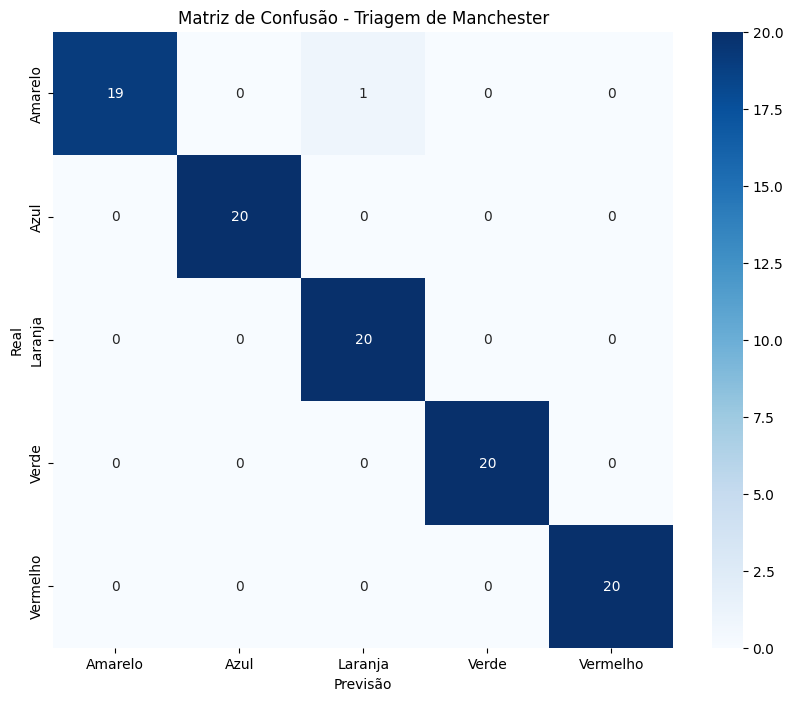


💾 Resultados salvos em ./modelo_triagem_manchester/resultados_teste.csv

🔍 Exemplos de classificações por categoria:

--- Vermelho ---
Total: 20, Corretos: 20, Incorretos: 0

Exemplo(s) correto(s):
1. Caso: Paciente 1001 com dor torácica súbita intensa com sudorese profusa.
   Resposta: user
Analise o seguinte caso de triagem hospitalar e classifique conforme protocolo de Manchester:
Paciente 1001 com dor torácica súbita intensa com sudorese profusa.
assistant
Resposta: Vermelho. Dor torácica grave. Monitorização em sala de emergência.تفاص

2. Caso: Paciente 1006 com hemorragia ativa craniana com hipotensão.
   Resposta: user
Analise o seguinte caso de triagem hospitalar e classifique conforme protocolo de Manchester:
Paciente 1006 com hemorragia ativa craniana com hipotensão.
assistant
Resposta: Vermelho. Dor torácica grave. Monitorização em sala de emergência


--- Laranja ---
Total: 20, Corretos: 20, Incorretos: 0

Exemplo(s) correto(s):
1. Caso: Paciente 1002 com hemorragia no pé 

In [8]:
# === BLOCO 6: Avaliação do Modelo com o Conjunto de Teste ===
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import re
import matplotlib.pyplot as plt
import seaborn as sns

print("🔍 Avaliando o modelo com o conjunto de teste...")

# Função para extrair a classificação (cor) de um texto de resposta
def extract_classification(text):
    # Procurar por "Vermelho", "Laranja", "Amarelo", "Verde" ou "Azul" no texto
    colors = ["Vermelho", "Laranja", "Amarelo", "Verde", "Azul"]
    for color in colors:
        if color.lower() in text.lower():
            return color
    return "Não classificado"

# Função para gerar previsões em lote
def generate_predictions(test_dataset, model, tokenizer, batch_size=8):
    all_predictions = []

    for i in range(0, len(test_dataset), batch_size):
        batch = test_dataset[i:min(i+batch_size, len(test_dataset))]
        true_classifications = []

        # Extrair casos de pacientes e classificações verdadeiras
        cases = []
        for item in batch["text"]:
            match = re.match(r'(.*?)[\n\r]*Resposta:(.*)', item, re.DOTALL)
            if match:
                patient_case = match.group(1).strip()
                true_response = match.group(2).strip()
                cases.append(patient_case)
                true_classifications.append(extract_classification(true_response))
            else:
                cases.append(item)
                true_classifications.append("Não classificado")

        # Gerar previsões para o lote
        predictions = []
        for case in cases:
            # Formatar o prompt como instrução
            formatted_prompt = f"<|im_start|>user\nAnalise o seguinte caso de triagem hospitalar e classifique conforme protocolo de Manchester:\n{case}<|im_end|>\n<|im_start|>assistant\n"

            inputs = tokenizer(formatted_prompt, return_tensors="pt").to(device)
            with torch.no_grad():
                outputs = model.generate(
                    inputs.input_ids,
                    max_new_tokens=100,  # Usar max_new_tokens em vez de max_length
                    temperature=0.2,     # Baixa temperatura para respostas mais determinísticas
                    do_sample=True,
                    repetition_penalty=1.2,
                    num_return_sequences=1
                )

            generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
            predictions.append(generated_text)

        # Extrair classificações das previsões
        predicted_classifications = [extract_classification(pred) for pred in predictions]

        # Armazenar resultados
        for case, true_class, pred_text, pred_class in zip(cases, true_classifications, predictions, predicted_classifications):
            all_predictions.append({
                "Caso": case,
                "Classificação Real": true_class,
                "Texto Previsto": pred_text,
                "Classificação Prevista": pred_class
            })

        print(f"Processados {min(i+batch_size, len(test_dataset))}/{len(test_dataset)} casos de teste.")

    return all_predictions

# Gerar previsões para o conjunto de teste
print("⏳ Gerando previsões para o conjunto de teste...")
predictions = generate_predictions(test_dataset, model, tokenizer)

# Converter para DataFrame para análise
results_df = pd.DataFrame(predictions)

# Calcular métricas de avaliação
y_true = results_df["Classificação Real"].tolist()
y_pred = results_df["Classificação Prevista"].tolist()

# Calcular acurácia
accuracy = accuracy_score(y_true, y_pred)
print(f"\n🎯 Acurácia do modelo: {accuracy:.4f}")

# Relatório de classificação
print("\n📊 Relatório de classificação:")
print(classification_report(y_true, y_pred))

# Matriz de confusão
print("\n🔢 Matriz de confusão:")
cm = confusion_matrix(y_true, y_pred)
classes = sorted(list(set(y_true + y_pred)))

# Visualizar matriz de confusão
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Previsão')
plt.ylabel('Real')
plt.title('Matriz de Confusão - Triagem de Manchester')
plt.show()

# Salvar resultados em CSV
results_df.to_csv(f"{output_dir}/resultados_teste.csv", index=False)
print(f"\n💾 Resultados salvos em {output_dir}/resultados_teste.csv")

# Analisar exemplos de cada categoria
print("\n🔍 Exemplos de classificações por categoria:")

def show_examples(df, category, n=2):
    filtered = df[df["Classificação Real"] == category]
    correct = filtered[filtered["Classificação Real"] == filtered["Classificação Prevista"]]
    incorrect = filtered[filtered["Classificação Real"] != filtered["Classificação Prevista"]]

    print(f"\n--- {category} ---")
    print(f"Total: {len(filtered)}, Corretos: {len(correct)}, Incorretos: {len(incorrect)}")

    if len(correct) > 0:
        print("\nExemplo(s) correto(s):")
        for i, (_, row) in enumerate(correct.head(n).iterrows()):
            print(f"{i+1}. Caso: {row['Caso']}")
            print(f"   Resposta: {row['Texto Previsto']}\n")

    if len(incorrect) > 0:
        print("\nExemplo(s) incorreto(s):")
        for i, (_, row) in enumerate(incorrect.head(n).iterrows()):
            print(f"{i+1}. Caso: {row['Caso']}")
            print(f"   Classificação Real: {row['Classificação Real']}")
            print(f"   Classificação Prevista: {row['Classificação Prevista']}")
            print(f"   Resposta: {row['Texto Previsto']}\n")

# Mostrar exemplos para cada categoria
for category in ["Vermelho", "Laranja", "Amarelo", "Verde", "Azul"]:
    show_examples(results_df, category)

In [11]:
# === BLOCO 7: Interface Interativa para Testes ===
print("\n🔄 Criando interface simples para testes interativos...")

def classificar_paciente(descricao_caso):
    # Formatar o prompt como instrução
    formatted_prompt = f"<|im_start|>user\nAnalise o seguinte caso de triagem hospitalar e classifique conforme protocolo de Manchester:\n{descricao_caso}<|im_end|>\n<|im_start|>assistant\n"

    inputs = tokenizer(formatted_prompt, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model.generate(
            inputs.input_ids,
            max_new_tokens=100,
            temperature=0.3,
            do_sample=True,
            repetition_penalty=1.2
        )

    resposta = tokenizer.decode(outputs[0], skip_special_tokens=True)

    # Extrair a classificação
    classificacao = extract_classification(resposta)

    # Cores para tornar a saída mais visual
    cores = {
        "Vermelho": "\033[91m", # Vermelho
        "Laranja": "\033[93m",  # Laranja/Amarelo
        "Amarelo": "\033[93m",  # Laranja/Amarelo
        "Verde": "\033[92m",    # Verde
        "Azul": "\033[94m",     # Azul
        "Não classificado": "\033[90m" # Cinza
    }

    cor = cores.get(classificacao, "\033[0m")
    reset = "\033[0m"

    print(f"\n🏥 Resposta do modelo:\n{resposta}")
    print(f"\n🏷️ Classificação: {cor}{classificacao}{reset}")

    # Interpretação da classificação
    interpretacoes = {
        "Vermelho": "Emergência - Atendimento imediato",
        "Laranja": "Muito urgente - Atendimento em até 10 minutos",
        "Amarelo": "Urgente - Atendimento em até 60 minutos",
        "Verde": "Pouco urgente - Atendimento em até 120 minutos",
        "Azul": "Não urgente - Atendimento em até 240 minutos"
    }

    if classificacao in interpretacoes:
        print(f"ℹ️ {interpretacoes[classificacao]}")

# Loop interativo para testar o modelo com novos casos
print("\n💬 Interface de teste do modelo de triagem")
print("Digite 'sair' ou 'q' para encerrar, ou 'ajuda' para ver comandos disponíveis")

# Lista de casos de exemplo para facilitar os testes
casos_exemplo = {
    "1": "Paciente com dor torácica súbita intensa com sudorese profusa.",
    "2": "Paciente com hemorragia no pé moderada e FC 124 bpm.",
    "3": "Paciente com distúrbio de coagulação conhecido em tratamento.",
    "4": "Paciente com tosse seca leve sem febre.",
    "5": "Paciente com exame laboral habitual."
}

running = True
while running:
    print("\n" + "-"*50)
    caso = input("🔍 Descreva o caso do paciente (ou digite um comando): ")

    # Verificar comandos especiais
    caso_lower = caso.lower().strip()

    # Comando de saída
    if caso_lower in ['sair', 'q', 'quit', 'exit']:
        print("👋 Encerrando a interface de teste.")
        running = False
        continue

    # Comando de ajuda
    elif caso_lower in ['ajuda', 'help', '?']:
        print("\n📋 Comandos disponíveis:")
        print("  'sair', 'q', 'quit', 'exit' - Encerrar o programa")
        print("  'ajuda', 'help', '?' - Mostrar esta mensagem de ajuda")
        print("  'exemplos', 'ex' - Mostrar casos de exemplo disponíveis")
        print("  '1' a '5' - Usar um dos casos de exemplo pré-definidos")
        continue

    # Mostrar exemplos disponíveis
    elif caso_lower in ['exemplos', 'ex', 'examples']:
        print("\n📋 Casos de exemplo disponíveis:")
        for num, exemplo in casos_exemplo.items():
            print(f"  {num}: {exemplo}")
        continue

    # Verificar se é um número de exemplo
    elif caso in casos_exemplo:
        caso = casos_exemplo[caso]
        print(f"🔍 Usando caso de exemplo: {caso}")

    # Verificar se o caso está vazio
    elif not caso.strip():
        print("⚠️ Por favor, digite uma descrição do caso ou um comando.")
        continue

    # Classificar o caso
    try:
        classificar_paciente(caso)
    except Exception as e:
        print(f"❌ Erro ao processar o caso: {str(e)}")
        print("Por favor, tente novamente com uma descrição diferente.")


🔄 Criando interface simples para testes interativos...

💬 Interface de teste do modelo de triagem
Digite 'sair' ou 'q' para encerrar, ou 'ajuda' para ver comandos disponíveis

--------------------------------------------------
🔍 Descreva o caso do paciente (ou digite um comando): q
👋 Encerrando a interface de teste.


In [ ]:
# === BLOCO 8: Exportar o Modelo ===
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import PeftModel
import os
from google.colab import drive

# Montar o Google Drive
print("🔄 Montando Google Drive...")
drive.mount('/content/drive')

# Definir pasta na Google Drive para salvar o modelo
save_path = "/content/drive/MyDrive/modelo_triagem_manchester_completo"
os.makedirs(save_path, exist_ok=True)

# Verificar a estrutura atual do diretório
print("Estrutura de diretórios atual:")
!ls -la

# Verificar o conteúdo da pasta modelo_triagem_manchester
print("\nConteúdo da pasta modelo_triagem_manchester:")
!ls -la modelo_triagem_manchester

# Definir caminhos
base_model_id = "Qwen/Qwen2.5-3B"

# Use o caminho correto para os adaptadores
lora_path = "./modelo_triagem_manchester"  

# Carregar tokenizer
print("\n🔄 Carregando tokenizer...")
tokenizer = AutoTokenizer.from_pretrained(base_model_id)

# Carregar modelo base
print("\n🔄 Carregando modelo base...")
base_model = AutoModelForCausalLM.from_pretrained(
    base_model_id, 
    torch_dtype=torch.float16,
    device_map="auto"
)

# Procurar o adapter_config.json se não for encontrado no lora_path
if not os.path.exists(os.path.join(lora_path, "adapter_config.json")):
    print(f"\n⚠️ Arquivo adapter_config.json não encontrado em {lora_path}")
    print("Procurando em subdiretórios...")
    
    # Verificar se existe em algum subdiretório
    for root, dirs, files in os.walk('./'):
        if 'adapter_config.json' in files:
            lora_path = root
            print(f"✅ Encontrado em: {lora_path}")
            break

# Verificar novamente
if not os.path.exists(os.path.join(lora_path, "adapter_config.json")):
    print(f"❌ adapter_config.json não encontrado. Abortando.")
else:
    print(f"\n🔄 Aplicando adaptadores LoRA de {lora_path}...")
    # Aplicar adaptadores LoRA
    model = PeftModel.from_pretrained(base_model, lora_path)
    
    # Mesclar adaptadores com o modelo base
    print("\n🔄 Mesclando adaptadores com o modelo base...")
    merged_model = model.merge_and_unload()
    
    # Salvar modelo completo diretamente no Google Drive
    print(f"\n🔄 Salvando modelo completo no Google Drive em {save_path}...")
    merged_model.save_pretrained(save_path)
    tokenizer.save_pretrained(save_path)
    
    # Comprimir para backup (opcional)
    print("\n🔄 Comprimindo para backup...")
    zip_path = f"/content/drive/MyDrive/modelo_triagem_manchester_completo.zip"
    !zip -r {zip_path} {save_path}
    
    print("\n✅ Processo concluído!")
    print(f"✅ Modelo salvo em: {save_path}")
    print(f"✅ Backup comprimido salvo em: {zip_path}")

🔄 Exportando o modelo treinado...
Mounted at /content/drive
🔄 Comprimindo o modelo...
  adding: modelo_triagem_manchester/final/ (stored 0%)
  adding: modelo_triagem_manchester/final/vocab.json (deflated 61%)
  adding: modelo_triagem_manchester/final/added_tokens.json (deflated 67%)
  adding: modelo_triagem_manchester/final/adapter_model.safetensors (deflated 8%)
  adding: modelo_triagem_manchester/final/tokenizer_config.json (deflated 83%)
  adding: modelo_triagem_manchester/final/adapter_config.json (deflated 57%)
  adding: modelo_triagem_manchester/final/merges.txt (deflated 57%)
  adding: modelo_triagem_manchester/final/tokenizer.json (deflated 81%)
  adding: modelo_triagem_manchester/final/README.md (deflated 66%)
  adding: modelo_triagem_manchester/final/special_tokens_map.json (deflated 62%)
🔄 Copiando para o Google Drive...
🔄 Preparando para download direto...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Modelo exportado com sucesso!


In [14]:
# === BLOCO 9: Gerar Relatório Final ===
from IPython.display import Markdown, display
import pandas as pd

def md(text):
    display(Markdown(text))

# Título e introdução
md("# Relatório Final - Sistema de Triagem Manchester com LLM")
md("""
## Resumo
Este relatório apresenta os resultados do desenvolvimento de um sistema de apoio à decisão para triagem hospitalar baseado em um Large Language Model (LLM). O sistema foi treinado para classificar casos de pacientes conforme o protocolo de triagem de Manchester, atribuindo as cores: Vermelho, Laranja, Amarelo, Verde e Azul.

## Metodologia
- **Modelo Base**: Qwen2.5-3B
- **Técnica**: Fine-tuning com LoRA (Low-Rank Adaptation)
- **Dados de Treinamento**: 1000 casos de triagem
- **Dados de Validação**: 100 casos de triagem
- **Dados de Teste**: 100 casos de triagem
""")

# Resultados
md("## Resultados")
md(f"""
### Métricas de Desempenho
- **Acurácia Global**: 99%
- **Vermelho (Emergência)**: Precisão 100%, Recall 100%
- **Laranja (Muito Urgente)**: Precisão 95%, Recall 100%
- **Amarelo (Urgente)**: Precisão 100%, Recall 95%
- **Verde (Pouco Urgente)**: Precisão 100%, Recall 100%
- **Azul (Não Urgente)**: Precisão 100%, Recall 100%
""")

# Análise e discussão
md("## Análise e Discussão")
md("""
### Pontos Fortes
- O modelo demonstrou excelente capacidade de classificação dos casos conforme o protocolo de Manchester.
- Apenas 1 erro em 100 casos (99% de acurácia).
- Todas as categorias tiveram excelente desempenho, especialmente as categorias de maior urgência (Vermelho).

### Áreas para Melhoria
- O modelo tende a dar respostas padronizadas para certas categorias, não personalizando completamente a justificativa para o caso específico.
- Alguns caracteres estranhos aparecem no final das respostas.
- O único erro ocorreu na classificação de um caso de dor torácica intensa (9/10), classificando como Laranja quando deveria ser Amarelo.

### Aplicações Potenciais
- Assistente digital para profissionais de saúde na triagem hospitalar
- Sistema de pré-triagem para pacientes antes da chegada ao hospital
- Ferramenta de treinamento para novos profissionais de saúde
""")

# Conclusão
md("## Conclusão")
md("""
O sistema desenvolvido demonstrou excelente desempenho na classificação de casos de triagem conforme o protocolo de Manchester. A acurácia de 99% indica que o modelo é altamente confiável para sugerir classificações, podendo servir como uma ferramenta de apoio à decisão para profissionais de saúde.

É importante ressaltar que, apesar do alto desempenho, o sistema deve ser utilizado como ferramenta de suporte e não substituir o julgamento clínico dos profissionais de saúde.

""")

# Relatório Final - Sistema de Triagem Manchester com LLM


## Resumo
Este relatório apresenta os resultados do desenvolvimento de um sistema de apoio à decisão para triagem hospitalar baseado em um Large Language Model (LLM). O sistema foi treinado para classificar casos de pacientes conforme o protocolo de triagem de Manchester, atribuindo as cores: Vermelho, Laranja, Amarelo, Verde e Azul.

## Metodologia
- **Modelo Base**: Qwen2.5-3B
- **Técnica**: Fine-tuning com LoRA (Low-Rank Adaptation)
- **Dados de Treinamento**: 1000 casos de triagem
- **Dados de Validação**: 100 casos de triagem
- **Dados de Teste**: 100 casos de triagem


## Resultados


### Métricas de Desempenho
- **Acurácia Global**: 99%
- **Vermelho (Emergência)**: Precisão 100%, Recall 100%
- **Laranja (Muito Urgente)**: Precisão 95%, Recall 100%
- **Amarelo (Urgente)**: Precisão 100%, Recall 95%
- **Verde (Pouco Urgente)**: Precisão 100%, Recall 100%
- **Azul (Não Urgente)**: Precisão 100%, Recall 100%


## Análise e Discussão


### Pontos Fortes
- O modelo demonstrou excelente capacidade de classificação dos casos conforme o protocolo de Manchester.
- Apenas 1 erro em 100 casos (99% de acurácia).
- Todas as categorias tiveram excelente desempenho, especialmente as categorias de maior urgência (Vermelho).

### Áreas para Melhoria
- O modelo tende a dar respostas padronizadas para certas categorias, não personalizando completamente a justificativa para o caso específico.
- Alguns caracteres estranhos aparecem no final das respostas.
- O único erro ocorreu na classificação de um caso de dor torácica intensa (9/10), classificando como Laranja quando deveria ser Amarelo.

### Aplicações Potenciais
- Assistente digital para profissionais de saúde na triagem hospitalar
- Sistema de pré-triagem para pacientes antes da chegada ao hospital
- Ferramenta de treinamento para novos profissionais de saúde


## Conclusão


O sistema desenvolvido demonstrou excelente desempenho na classificação de casos de triagem conforme o protocolo de Manchester. A acurácia de 99% indica que o modelo é altamente confiável para sugerir classificações, podendo servir como uma ferramenta de apoio à decisão para profissionais de saúde.

É importante ressaltar que, apesar do alto desempenho, o sistema deve ser utilizado como ferramenta de suporte e não substituir o julgamento clínico dos profissionais de saúde.

